DIEU Alexis 22202609
Ballester Mathéo 22204408

Durant ce projet nous essayeront de déterminer les causes d'une attente à l'hospital. De plus nous essayeront de simuler le temps d'attente d'un patient.
Pour cela nous commencerons par une analyse exploratoire pour trouver les corrélations. Deuxièmement nous testerons les modèles pour déterminer quel est le meilleur modèle. Pour finir nous feront la simulation.

# **Importations des données**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import time
from sklearn.tree import DecisionTreeRegressor

RANDOM_STATE=42
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/projet_ML/ER_Wait_Time_Dataset.csv')

# Afficher les premières lignes et informations générales
print("Premières lignes du dataset:")
print(df.head())
print("\nInformations générales:")
print(df.info())
print("\nStatistiques descriptives:")
print(df.describe())



Premières lignes du dataset:
               Visit ID Patient ID Hospital ID                 Hospital Name  \
0  HOSP-1-20240210-0001  PAT-00001      HOSP-1  Springfield General Hospital   
1  HOSP-3-20241128-0001  PAT-00002      HOSP-3  Northside Community Hospital   
2  HOSP-3-20240930-0002  PAT-00003      HOSP-3  Northside Community Hospital   
3  HOSP-2-20240227-0001  PAT-00004      HOSP-2      Riverside Medical Center   
4  HOSP-1-20240306-0002  PAT-00005      HOSP-1  Springfield General Hospital   

  Region           Visit Date Day of Week  Season   Time of Day Urgency Level  \
0  Urban  2024-02-10 20:20:56    Saturday  Winter  Late Morning        Medium   
1  Rural  2024-11-28 02:07:47    Thursday    Fall       Evening        Medium   
2  Rural  2024-09-30 04:02:28      Monday    Fall       Evening           Low   
3  Urban  2024-02-27 00:31:13     Tuesday  Winter       Evening          High   
4  Urban  2024-03-06 16:52:26   Wednesday  Spring     Afternoon           Low   

   

# **Manipulation des données**

## **Analyse exploratoire des données avancée :**

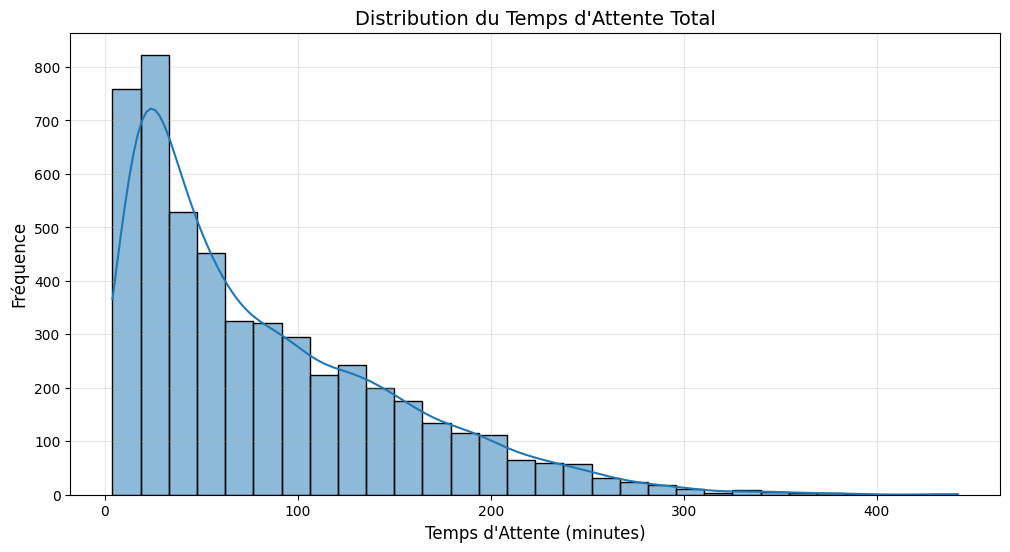

In [ ]:
# 1. Distribution du temps d'attente total
plt.figure(figsize=(12, 6))
sns.histplot(df['Total Wait Time (min)'], kde=True, bins=30)
plt.title('Distribution du Temps d\'Attente Total', fontsize=14)
plt.xlabel('Temps d\'Attente (minutes)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

On peut voir que le temps d’attente général se situe aux alentours des 20 à 40 minutes. Mais on peut notifier que certains patients on attendus 350mn soit presque 6h.

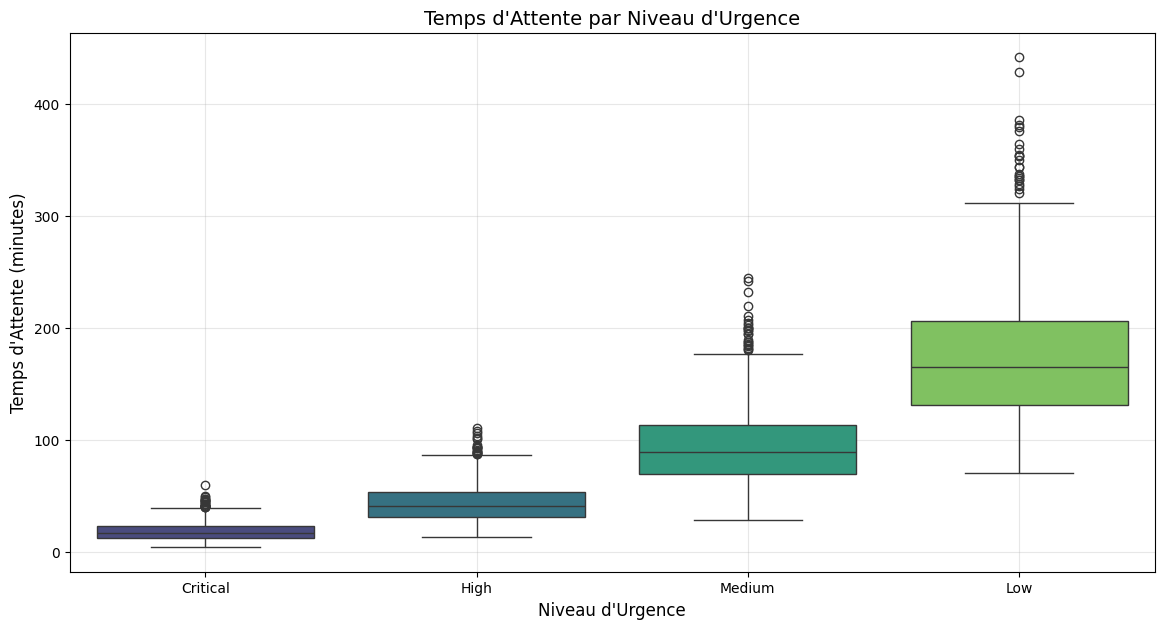

In [ ]:
# 2. Boxplot du temps d'attente par niveau d'urgence
plt.figure(figsize=(14, 7))
sns.boxplot(x='Urgency Level', y='Total Wait Time (min)', data=df,
            order=['Critical', 'High', 'Medium', 'Low'], palette='viridis')
plt.title('Temps d\'Attente par Niveau d\'Urgence', fontsize=14)
plt.xlabel('Niveau d\'Urgence', fontsize=12)
plt.ylabel('Temps d\'Attente (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

On voit bien que le niveau d’urgence est correctement corrélé au temps d’attente puisque nos box plot sont correctement repartis. Plus l’urgence est grande, moins l’attente est longue.

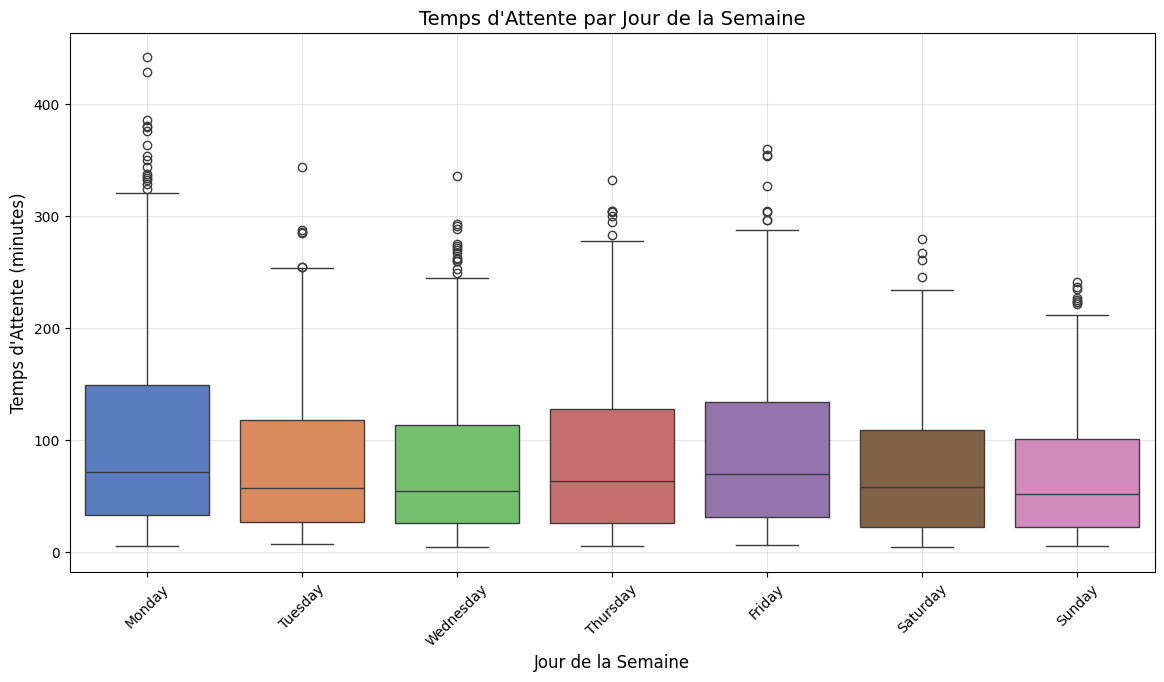

In [ ]:
# 3. Boxplot du temps d'attente par jour de la semaine
plt.figure(figsize=(14, 7))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='Day of Week', y='Total Wait Time (min)', data=df, order=day_order, palette='muted')
plt.title('Temps d\'Attente par Jour de la Semaine', fontsize=14)
plt.xlabel('Jour de la Semaine', fontsize=12)
plt.ylabel('Temps d\'Attente (minutes)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

Etonnament, le lundi il y a plus d’attente que les autres jours, ce qui me semble contre-inuitif, j’aurai pense que c’était le dimanche ou il y a le plus d’attente.

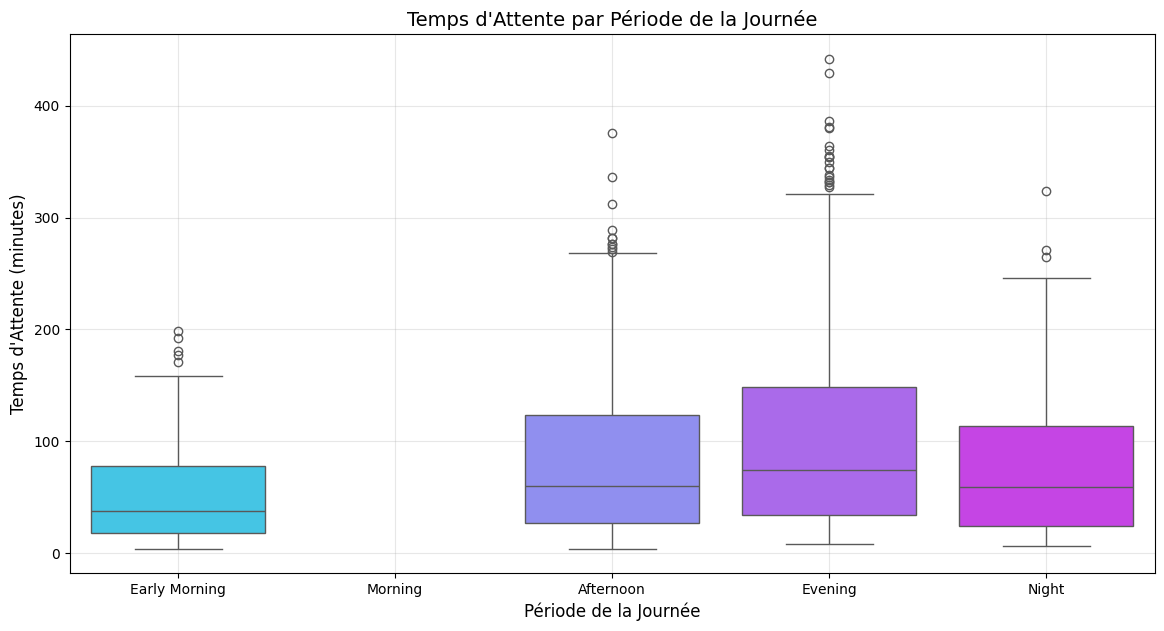

In [ ]:
# 4. Boxplot du temps d'attente par période de la journée
plt.figure(figsize=(14, 7))
time_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']
sns.boxplot(x='Time of Day', y='Total Wait Time (min)', data=df, order=time_order, palette='cool')
plt.title('Temps d\'Attente par Période de la Journée', fontsize=14)
plt.xlabel('Période de la Journée', fontsize=12)
plt.ylabel('Temps d\'Attente (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Le meilleur moment de la journée pour aller aux urgences serait donc tôt le matin, comme on pourrait s’y attendre. Le soir est le pire moment.

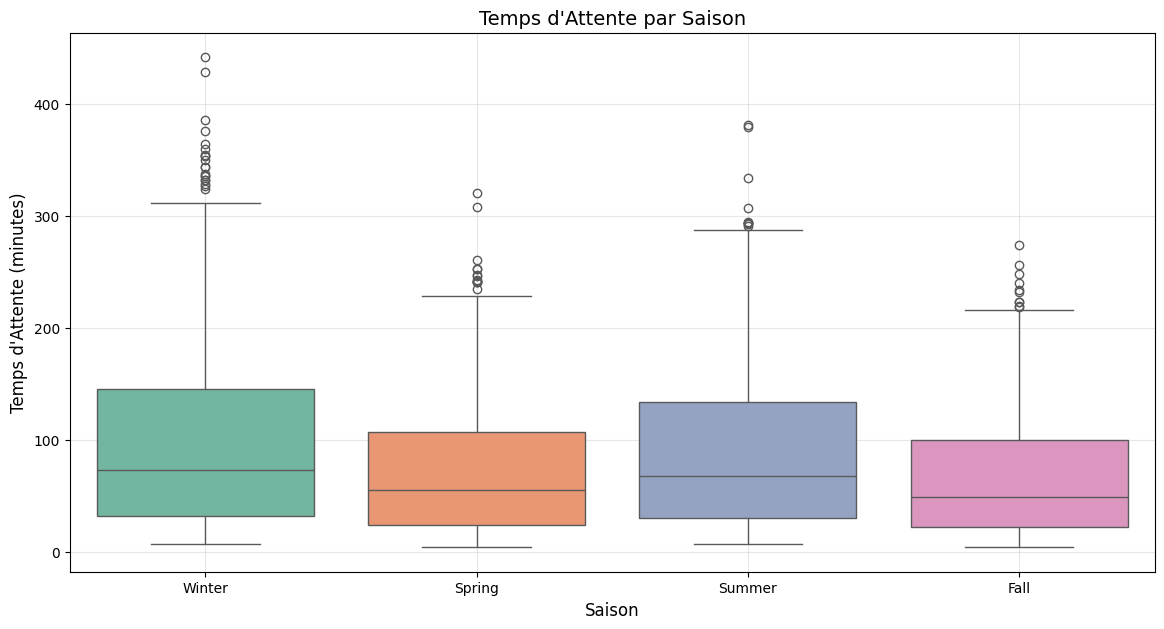

In [ ]:
# 5. Boxplot du temps d'attente par saison
plt.figure(figsize=(14, 7))
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
sns.boxplot(x='Season', y='Total Wait Time (min)', data=df, order=season_order, palette='Set2')
plt.title('Temps d\'Attente par Saison', fontsize=14)
plt.xlabel('Saison', fontsize=12)
plt.ylabel('Temps d\'Attente (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Le temps d’attente selon la saison change, ce qui est assez étonnant a mes yeux, j’aurai cru que cela n’impactait pas vraiment le temps d’attente.

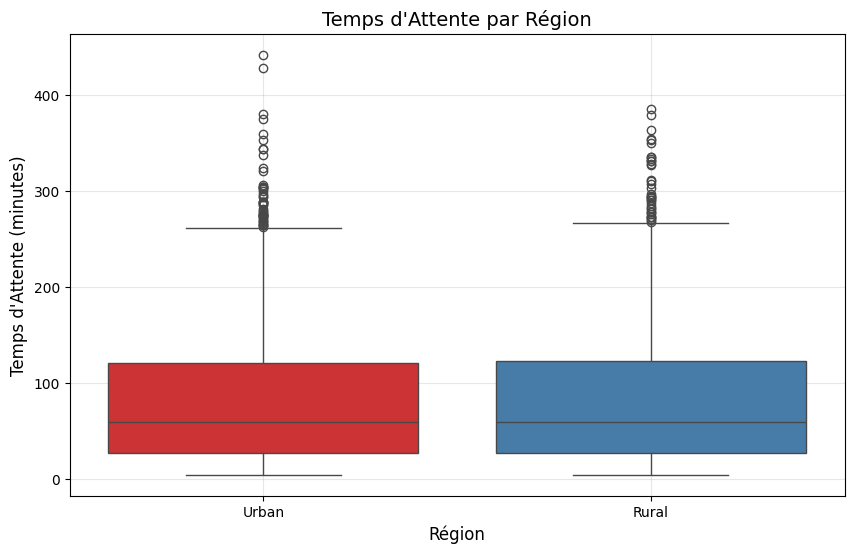

In [ ]:
# 6. Boxplot du temps d'attente par région
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Total Wait Time (min)', data=df, palette='Set1')
plt.title('Temps d\'Attente par Région', fontsize=14)
plt.xlabel('Région', fontsize=12)
plt.ylabel('Temps d\'Attente (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

C’est exactement le même. On ne peut donc rien en tirer d'intéressant

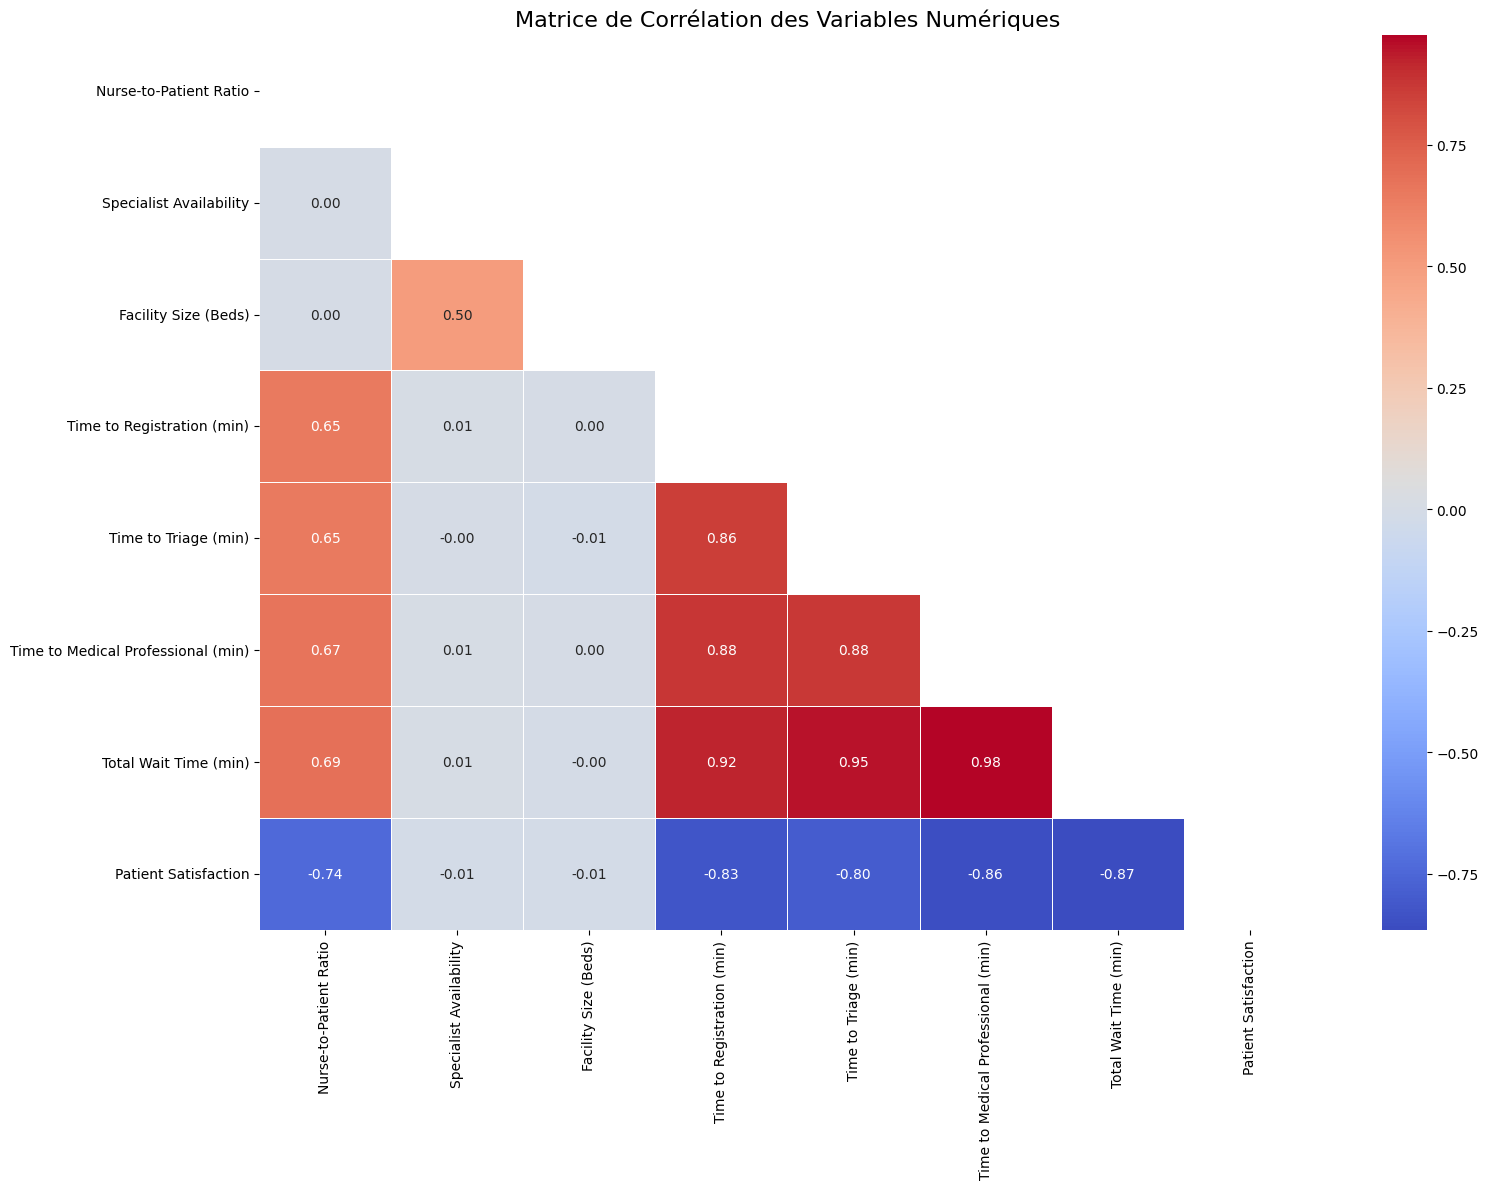

In [ ]:
# 7. Heatmap des corrélations entre les variables numériques
plt.figure(figsize=(16, 12))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation = df[numeric_cols].corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Matrice de Corrélation des Variables Numériques', fontsize=16)
plt.tight_layout()
plt.show()

Appliqué uniquement sur les variables numériques…
On peut voir que les correlations les plus fortes sont parfaitement logiques (temps d'attente avec temps pour voir un proffessionnel, confirmé ensuite par le plus important dans le temps d'attente).


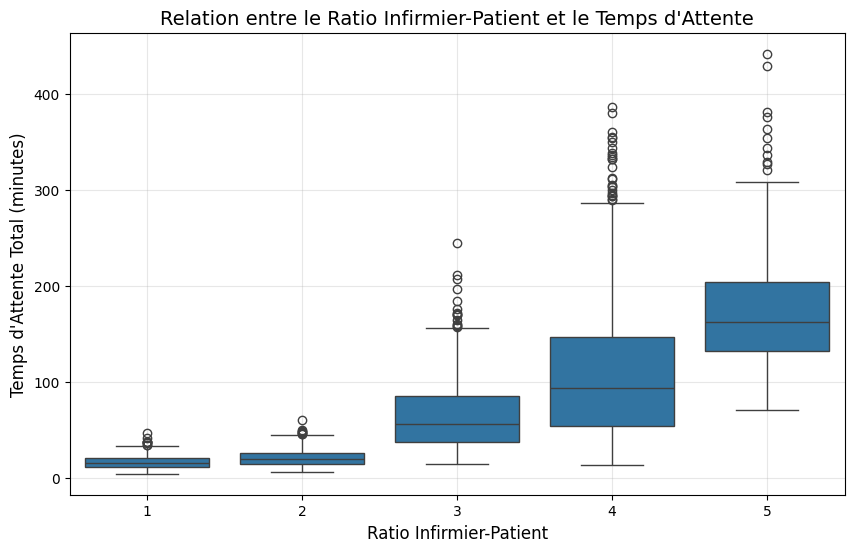

In [ ]:
# 8. Regplot entre le ratio infirmier-patient et le temps d'attente total
plt.figure(figsize=(10, 6))
sns.boxplot(x='Nurse-to-Patient Ratio', y='Total Wait Time (min)', data=df)
plt.title('Relation entre le Ratio Infirmier-Patient et le Temps d\'Attente', fontsize=14)
plt.xlabel('Ratio Infirmier-Patient', fontsize=12)
plt.ylabel('Temps d\'Attente Total (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

On peut voir qu’il est cohérent que le nombre de patient par infirmier augmentant, le temps d’attente augmente également, plutôt linéairement d’ailleurs.

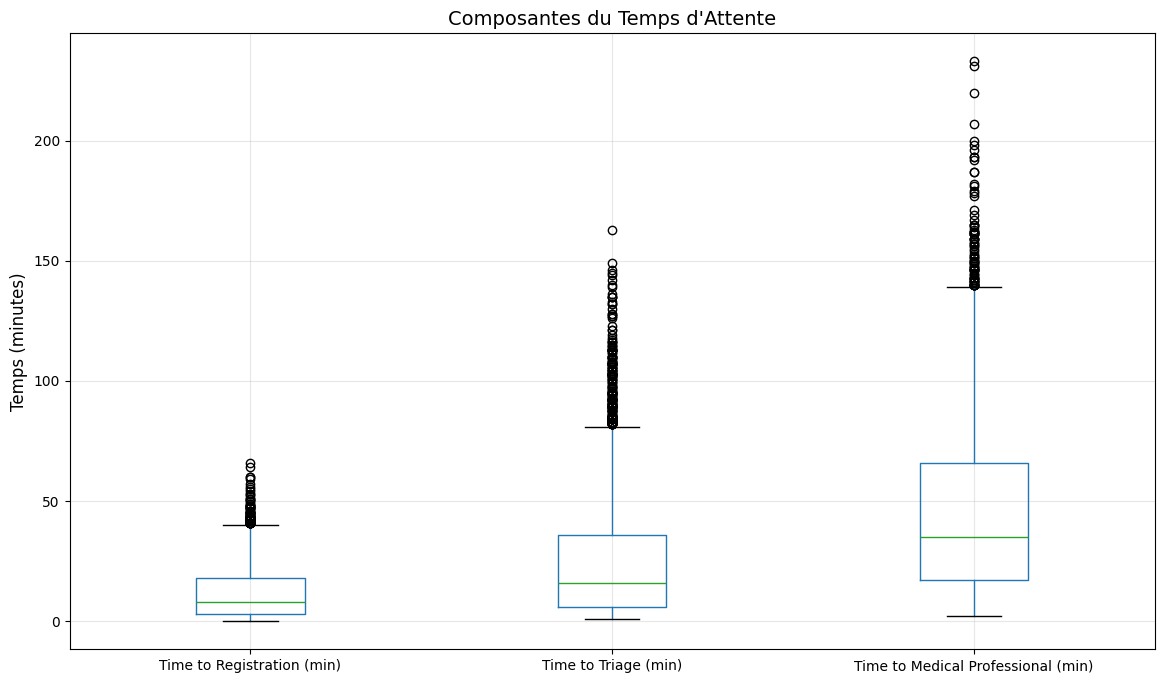

In [ ]:
# 9. Visualisation des composantes du temps d'attente
plt.figure(figsize=(14, 8))
wait_time_components = df[['Time to Registration (min)', 'Time to Triage (min)', 'Time to Medical Professional (min)']]
wait_time_components.boxplot()
plt.title('Composantes du Temps d\'Attente', fontsize=14)
plt.ylabel('Temps (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Le plus long est donc l’attente de voir un medecin, ce qui confirme les données de la heatmap.

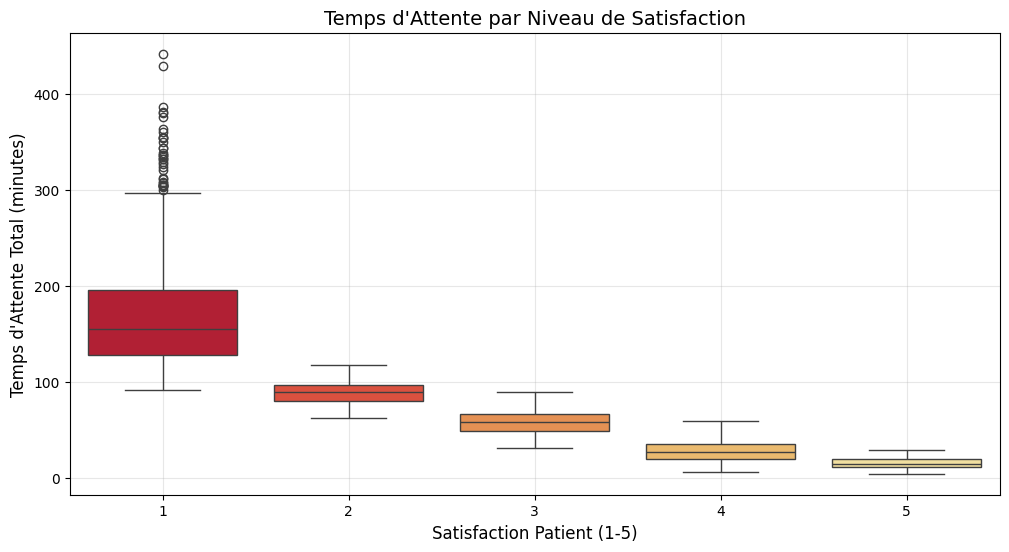

In [ ]:
# 10. Relation entre la satisfaction patient et le temps d'attente
plt.figure(figsize=(12, 6))
sns.boxplot(x='Patient Satisfaction', y='Total Wait Time (min)', data=df, palette='YlOrRd_r')
plt.title('Temps d\'Attente par Niveau de Satisfaction', fontsize=14)
plt.xlabel('Satisfaction Patient (1-5)', fontsize=12)
plt.ylabel('Temps d\'Attente Total (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Evidemment, plus l'attente est longue, moins la notation est bonne.

## **Feature engineering "temps & flux"**


Objectif : extraire des informations temporelles et créer des variables dérivées (variable créée à partir de données existantes dans le dataset).

In [ ]:
# Convertir la colonne 'Visit Date' en datetime
df['Visit Date'] = pd.to_datetime(df['Visit Date'])

# Extraire les composantes temporelles
df['Hour'] = df['Visit Date'].dt.hour
df['Month'] = df['Visit Date'].dt.month
df['Day'] = df['Visit Date'].dt.day
df['Year'] = df['Visit Date'].dt.year

# Créer une variable pour les weekends
df['Is Weekend'] = df['Day of Week'].isin(['Saturday', 'Sunday']).astype(int)

# Créer une variable pour la fin du mois (dernière semaine)
df['Is Month End'] = ((df['Visit Date'].dt.days_in_month - df['Visit Date'].dt.day) < 7).astype(int)

# Créer des variables pour les périodes de pointe
df['Is Peak Time'] = df['Time of Day'].isin(['Afternoon', 'Evening']).astype(int)
df['Is Monday Morning'] = ((df['Day of Week'] == 'Monday') & (df['Time of Day'].isin(['Morning', 'Early Morning']))).astype(int)

# Créer une variable booléenne pour l'urgence élevée
df['HighUrgency'] = df['Urgency Level'].isin(['Critical', 'High']).astype(int)

# Créer des variables d'interaction
df['HighUrgency_Peak'] = df['HighUrgency'] * df['Is Peak Time']
df['HighUrgency_Weekend'] = df['HighUrgency'] * df['Is Weekend']

# Créer une variable pour le flux de patients (approximation basée sur l'heure et le jour)
# Cette variable sera normalisée pour représenter un indice de fréquentation
busy_hours = {
    'Monday': [9, 10, 11, 14, 15, 16, 17, 18],
    'Tuesday': [10, 11, 15, 16, 17],
    'Wednesday': [10, 11, 15, 16, 17],
    'Thursday': [10, 11, 15, 16, 17],
    'Friday': [10, 11, 15, 16, 17, 18],
    'Saturday': [11, 12, 13, 14],
    'Sunday': [12, 13, 14, 15]
}

def get_flow_index(row):
    day = row['Day of Week']
    hour = row['Hour']

    # Base flow index
    if hour in busy_hours.get(day, []):
        return 2  # Heure de pointe
    elif hour in [h+1 for h in busy_hours.get(day, [])] or hour in [h-1 for h in busy_hours.get(day, [])]:
        return 1.5  # Proche des heures de pointe
    elif 8 <= hour <= 20:
        return 1  # Heures normales
    else:
        return 0.5  # Heures creuses

df['Flow Index'] = df.apply(get_flow_index, axis=1)

# Créer une interaction entre le flux et la taille de l'établissement
df['Flow_Size_Ratio'] = df['Flow Index'] / df['Facility Size (Beds)'] * 100

# Afficher les nouvelles colonnes
print("Variables dérivées créées:")
print(df[['Hour', 'Month', 'Is Weekend', 'Is Month End', 'HighUrgency',
          'HighUrgency_Peak', 'HighUrgency_Weekend', 'Flow Index', 'Flow_Size_Ratio']].head())

# Description des nouvelles variables
print("\nStatistiques des nouvelles variables:")
print(df[['Hour', 'Month', 'Is Weekend', 'Is Month End', 'HighUrgency',
          'HighUrgency_Peak', 'HighUrgency_Weekend', 'Flow Index', 'Flow_Size_Ratio']].describe())

# Sauvegarder le DataFrame enrichi
df.to_csv('er_data_enriched.csv', index=False)
print("\nDonnées enrichies sauvegardées dans 'er_data_enriched.csv'")

# Afficher la forme finale du jeu de données
print(f"\nForme finale du jeu de données: {df.shape} (lignes, colonnes)")

Variables dérivées créées:
   Hour  Month  Is Weekend  Is Month End  HighUrgency  HighUrgency_Peak  \
0    20      2           1             0            0                 0   
1     2     11           0             1            0                 0   
2     4      9           0             1            0                 0   
3     0      2           0             1            1                 1   
4    16      3           0             0            0                 0   

   HighUrgency_Weekend  Flow Index  Flow_Size_Ratio  
0                    0         1.0         1.086957  
1                    0         0.5         1.315789  
2                    0         0.5         1.315789  
3                    0         0.5         0.531915  
4                    0         2.0         2.702703  

Statistiques des nouvelles variables:
              Hour        Month   Is Weekend  Is Month End  HighUrgency  \
count  5000.000000  5000.000000  5000.000000    5000.00000  5000.000000   
mean     

# **Etude des modèles**

## **LinearRegression.**


Objectif:
Baseline pour comparer les modèles complexes, valider la pertinence des données, mesurer les progrès, identifier les tendances linéaires.

In [ ]:
# Charger les données enrichies
df = pd.read_csv('er_data_enriched.csv')

# Préparation des données pour la modélisation
# Sélection des variables pour la régression

# Variables catégorielles à encoder
cat_features = ['Region', 'Day of Week', 'Season', 'Time of Day', 'Urgency Level', 'Patient Outcome']

# Variables numériques à normaliser
num_features = ['Nurse-to-Patient Ratio', 'Specialist Availability', 'Facility Size (Beds)',
                'Time to Registration (min)', 'Time to Triage (min)', 'Hour', 'Month',
                'Is Weekend', 'Is Month End', 'HighUrgency', 'Flow Index']

# Cible
target = 'Total Wait Time (min)'

# Création des variables dummy pour les catégories
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Sélection des caractéristiques après encodage
X_columns = [col for col in df_encoded.columns if col != target and col != 'Visit Date'
             and col != 'Hospital Name' and col != 'Visit ID' and col != 'Patient ID'
             and col != 'Hospital ID' and col != 'Time to Medical Professional (min)'
             and col != 'Patient Outcome' and col != 'Patient Satisfaction']
# variables explicative:
X = df_encoded[X_columns]
# variables predictives:
y = df_encoded[target]

Nous avons enlevé les variables qui sont:
- la variable cible (Total Wait Time)
- les variables à identifiant unique
- la date de visite
- la variable la plus corrélée c'est à dire Time to Medical Professional (vu dans l'EDA)
- les variables non disponibles au moment de la prédiction (Patient Satisfaction, Patient Outcome)

In [ ]:
# Division en ensembles d'entraînement(80%) et de test(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")

# 1. Modèle de régression linéaire simple
print("\n--- Modèle de régression linéaire simple ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_train_preds = lr_model.predict(X_train)
lr_test_preds = lr_model.predict(X_test)

# Évaluation du modèle
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_train_preds))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_preds))
lr_train_r2 = r2_score(y_train, lr_train_preds)
lr_test_r2 = r2_score(y_test, lr_test_preds)

print(f"Train RMSE: {lr_train_rmse:.2f}")
print(f"Test RMSE: {lr_test_rmse:.2f}")
print(f"Train R²: {lr_train_r2:.4f}")
print(f"Test R²: {lr_test_r2:.4f}")

Dimensions de X_train: (4000, 37)
Dimensions de X_test: (1000, 37)

--- Modèle de régression linéaire simple ---
Train RMSE: 12.84
Test RMSE: 13.00
Train R²: 0.9644
Test R²: 0.9637


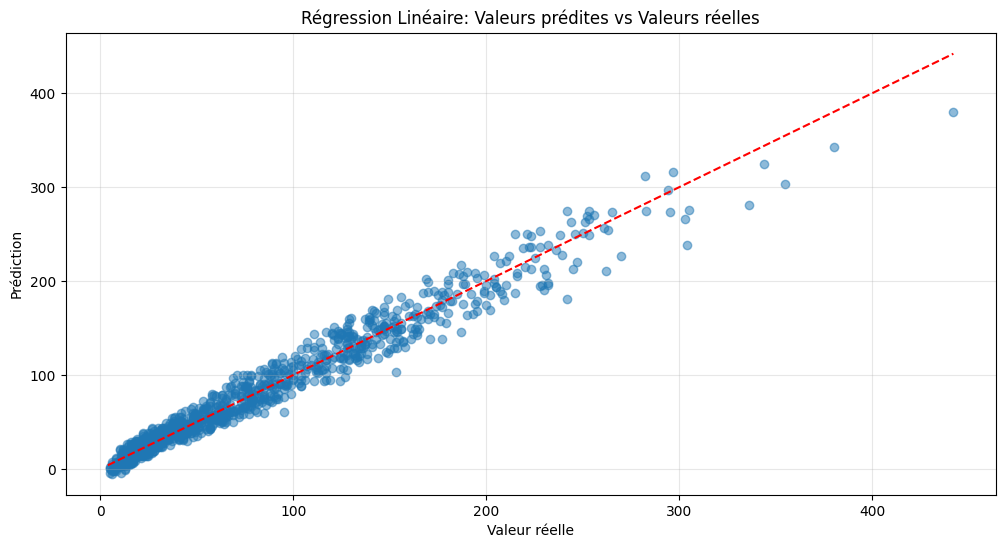

In [ ]:
# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.scatter(y_test, lr_test_preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Valeur réelle')
plt.ylabel('Prédiction')
plt.title('Régression Linéaire: Valeurs prédites vs Valeurs réelles')
plt.grid(True, alpha=0.3)
plt.show()

Le nuage de points suit bien la diagonale y = x, ce qui indique que les prédictions du modèle sont globalement correctes et non biaisées. Plus les points sont proches de cette droite, plus les erreurs de prédiction sont faibles. Cela est cohérent avec un bon coefficient R² et une faible RMSE.

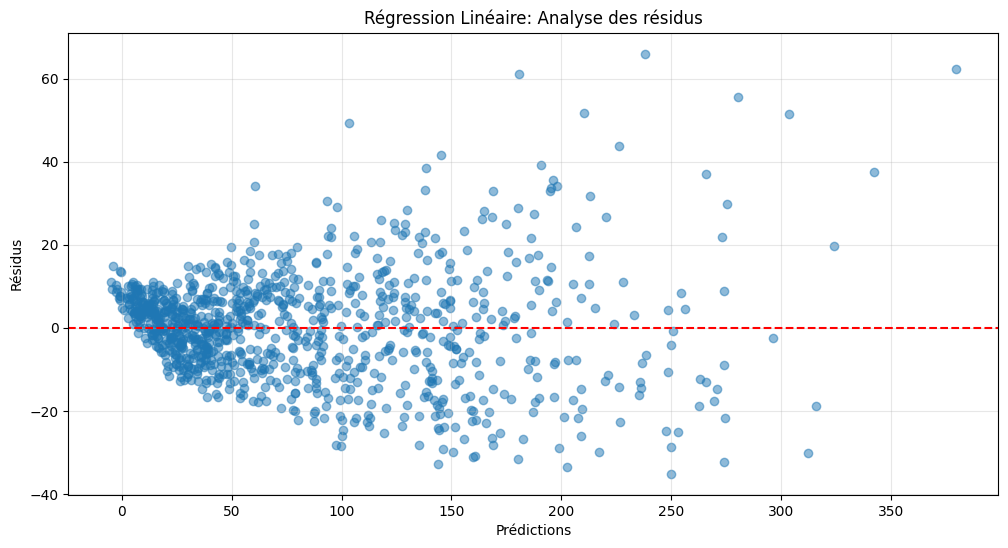

In [ ]:
# Visualisation des résidus
residuals = y_test - lr_test_preds
plt.figure(figsize=(12, 6))
plt.scatter(lr_test_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Régression Linéaire: Analyse des résidus')
plt.grid(True, alpha=0.3)
plt.show()

Le graphique des résidus montre que les erreurs du modèle sont globalement réparties autour de zéro, ce qui veut dire qu’il ne fait pas d’erreur systématique (il ne surestime ou ne sous-estime pas toujours). Par contre, on voit que plus les prédictions sont grandes, plus les erreurs sont dispersées : le modèle a donc du mal à bien prédire les valeurs élevées. Cette variation des erreurs s'appelle de l’hétéroscédasticité. On remarque aussi quelques points très éloignés de la ligne, donc certaines prédictions sont vraiment à côté de la plaque — ça vaudrait le coup d’explorer un peu plus ou de tester un autre modèle plus adapté.

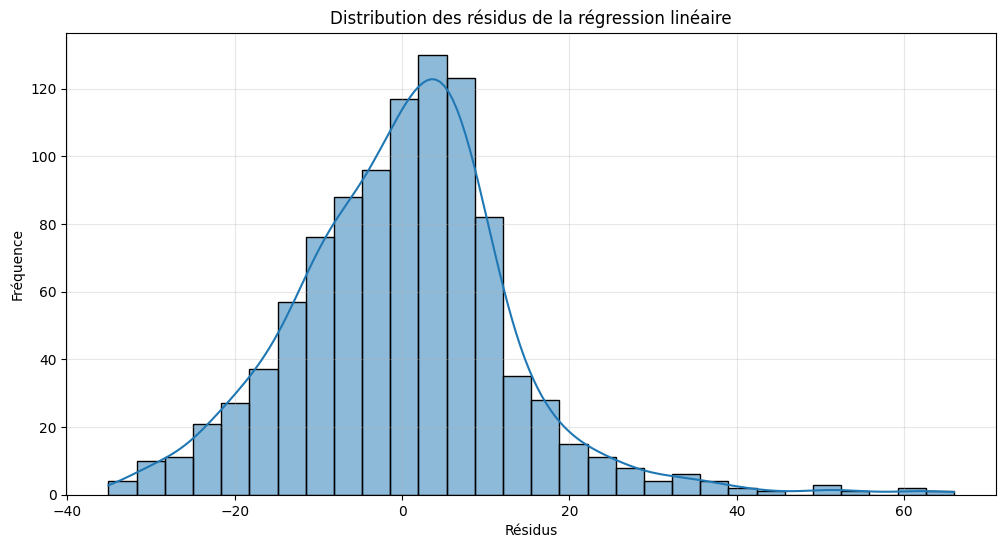

In [ ]:
# Distribution des résidus
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Distribution des résidus de la régression linéaire')
plt.grid(True, alpha=0.3)
plt.show()

Les résidus suivent à peu près une distribution normale, ce qui est plutôt rassurant. Ça veut dire que les erreurs sont bien réparties et que le modèle se comporte comme prévu, pas de gros décalages ou de comportements bizarres dans les prédictions.

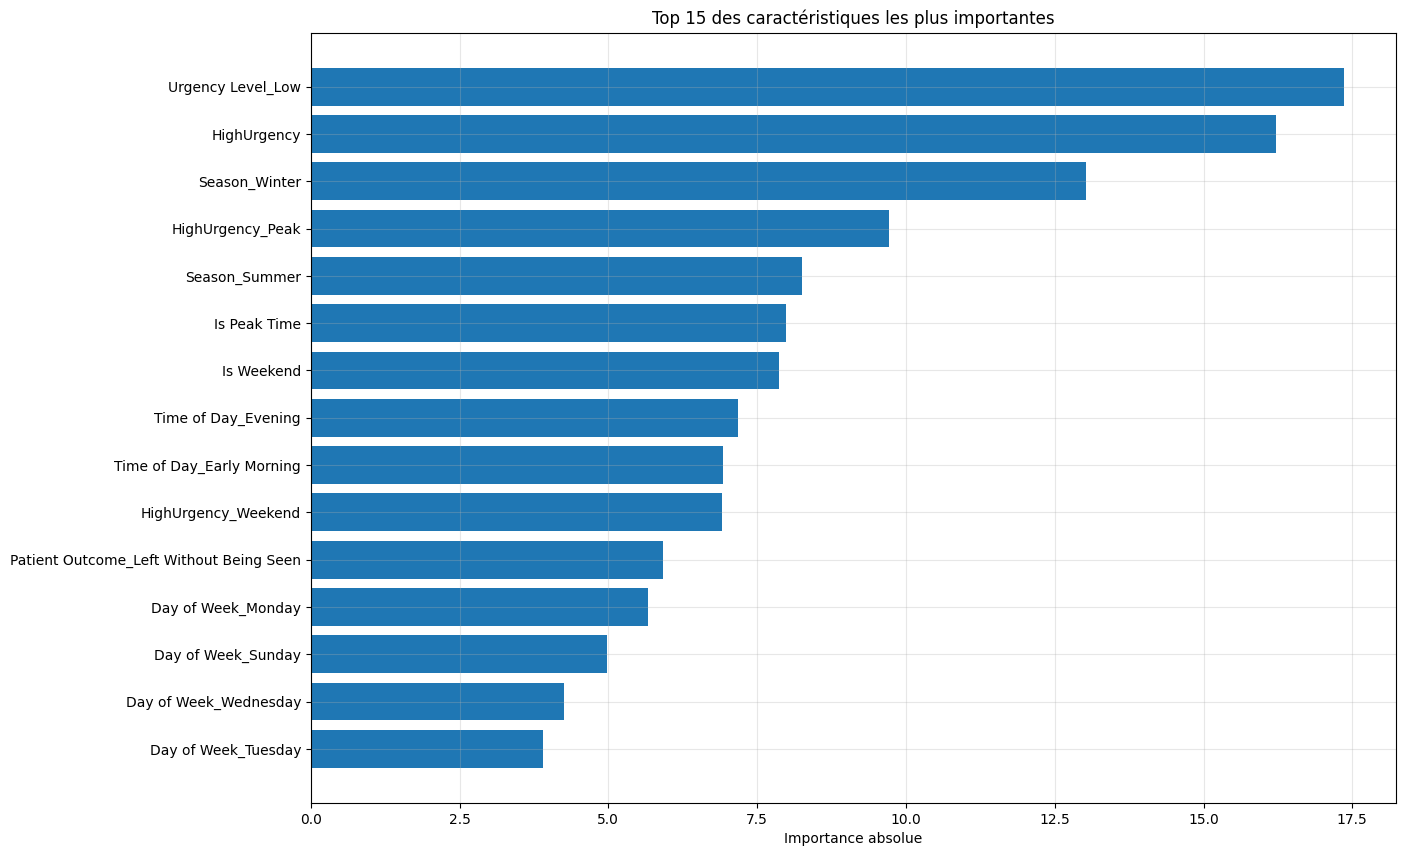


Le modèle de régression linéaire établit notre baseline avec un R² de 0.9637 sur les données de test.


In [ ]:
# Identifier les caractéristiques les plus importantes
coef_df = pd.DataFrame({
    'Variable': X_columns,
    'Coefficient': lr_model.coef_
})
top_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(14, 10))
plt.barh(top_features['Variable'][:15], top_features['Coefficient'].abs()[:15])
plt.xlabel('Importance absolue')
plt.title('Top 15 des caractéristiques les plus importantes')
plt.gca().invert_yaxis()  # Pour afficher les plus importantes en haut
plt.grid(True, alpha=0.3)
plt.show()

print("\nLe modèle de régression linéaire établit notre baseline avec un R² de {:.4f} sur les données de test.".format(lr_test_r2))

## **Ridge et Lasso avec GridSearchCV.**

Objetif:
Ridge/Lasso réduisent la complexité (sur-apprentissage) ; GridSearchCV optimise les hyperparamètres via validation croisée systématique.

In [ ]:
# Standardisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dimensions de X_train_scaled: {X_train_scaled.shape}")
print(f"Dimensions de X_test_scaled: {X_test_scaled.shape}")

# 1. Ridge Regression avec GridSearchCV
print("\n--- Régression Ridge avec GridSearchCV ---")
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train_scaled, y_train)

# Meilleur modèle Ridge
best_ridge = ridge_grid.best_estimator_
print(f"Meilleur alpha Ridge: {ridge_grid.best_params_['alpha']}")

# Évaluation du modèle Ridge
ridge_train_preds = best_ridge.predict(X_train_scaled)
ridge_test_preds = best_ridge.predict(X_test_scaled)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_train_preds))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_preds))
ridge_train_r2 = r2_score(y_train, ridge_train_preds)
ridge_test_r2 = r2_score(y_test, ridge_test_preds)

print(f"Ridge Train RMSE: {ridge_train_rmse:.2f}")
print(f"Ridge Test RMSE: {ridge_test_rmse:.2f}")
print(f"Ridge Train R²: {ridge_train_r2:.4f}")
print(f"Ridge Test R²: {ridge_test_r2:.4f}")

# 2. Lasso Regression avec GridSearchCV
print("\n--- Régression Lasso avec GridSearchCV ---")
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
lasso = Lasso(random_state=42, max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train_scaled, y_train)

# Meilleur modèle Lasso
best_lasso = lasso_grid.best_estimator_
print(f"Meilleur alpha Lasso: {lasso_grid.best_params_['alpha']}")

# Évaluation du modèle Lasso
lasso_train_preds = best_lasso.predict(X_train_scaled)
lasso_test_preds = best_lasso.predict(X_test_scaled)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_train_preds))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_preds))
lasso_train_r2 = r2_score(y_train, lasso_train_preds)
lasso_test_r2 = r2_score(y_test, lasso_test_preds)

print(f"Lasso Train RMSE: {lasso_train_rmse:.2f}")
print(f"Lasso Test RMSE: {lasso_test_rmse:.2f}")
print(f"Lasso Train R²: {lasso_train_r2:.4f}")
print(f"Lasso Test R²: {lasso_test_r2:.4f}")

# Comparer les résultats avec le modèle linéaire de base
print("\n--- Comparaison des modèles ---")
print(f"Ridge R² Test: {ridge_test_r2:.4f}")
print(f"Lasso R² Test: {lasso_test_r2:.4f}")

Dimensions de X_train_scaled: (4000, 37)
Dimensions de X_test_scaled: (1000, 37)

--- Régression Ridge avec GridSearchCV ---
Meilleur alpha Ridge: 10
Ridge Train RMSE: 12.84
Ridge Test RMSE: 13.01
Ridge Train R²: 0.9644
Ridge Test R²: 0.9636

--- Régression Lasso avec GridSearchCV ---
Meilleur alpha Lasso: 0.01
Lasso Train RMSE: 12.84
Lasso Test RMSE: 12.99
Lasso Train R²: 0.9644
Lasso Test R²: 0.9637

--- Comparaison des modèles ---
Ridge R² Test: 0.9636
Lasso R² Test: 0.9637


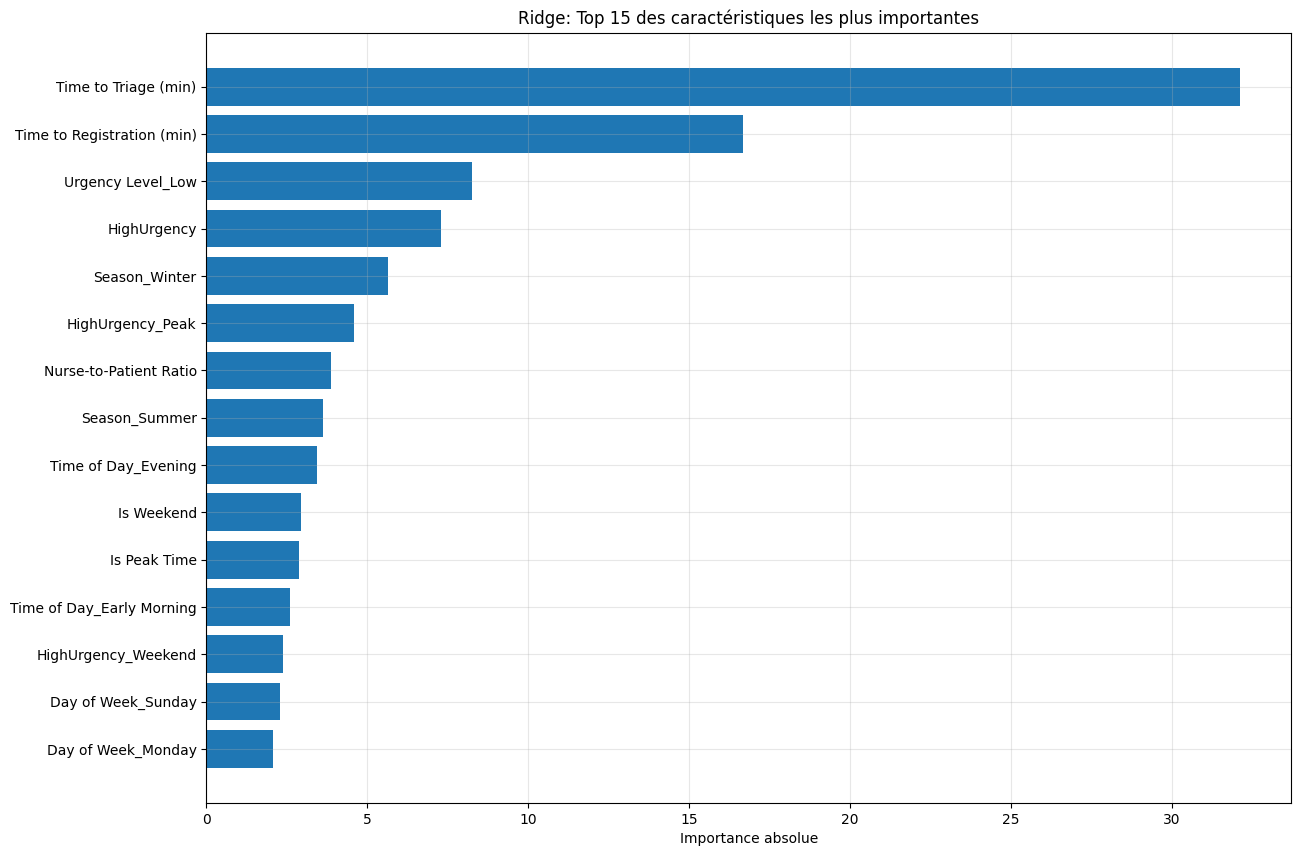

In [ ]:
# Visualiser les coefficients Ridge (tous sont conservés)
ridge_coefs = pd.DataFrame({
    'Variable': X_columns,
    'Coefficient Ridge': best_ridge.coef_
})
ridge_coefs = ridge_coefs.reindex(ridge_coefs['Coefficient Ridge'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(14, 10))
plt.barh(ridge_coefs['Variable'][:15], ridge_coefs['Coefficient Ridge'].abs()[:15])
plt.xlabel('Importance absolue')
plt.title('Ridge: Top 15 des caractéristiques les plus importantes')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

Le graphique montre les facteurs qui influencent le plus le temps d’attente aux urgences. Les deux plus importants sont le temps avant le triage et le temps avant l’enregistrement. Ensuite viennent la satisfaction du patient, le niveau d’urgence, la saison et le moment de la journée. En gros, pour réduire l’attente, il faudrait surtout améliorer la prise en charge dès l’arrivée.


Nombre de coefficients non nuls avec Lasso: 30 sur 37


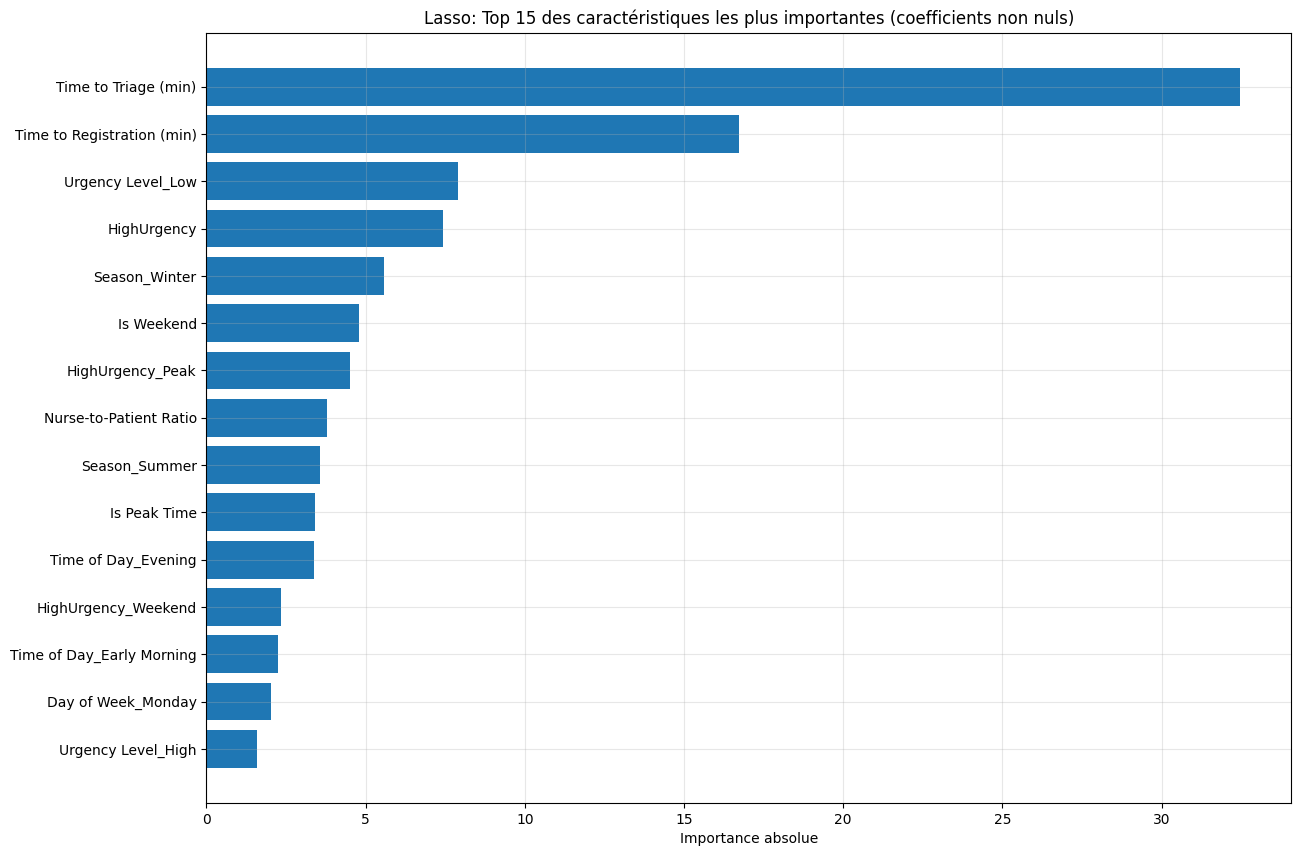

In [ ]:
# Visualiser les coefficients Lasso (certains peuvent être à zéro)
lasso_coefs = pd.DataFrame({
    'Variable': X_columns,
    'Coefficient Lasso': best_lasso.coef_
})
# Trier par valeur absolue des coefficients
lasso_coefs = lasso_coefs.reindex(lasso_coefs['Coefficient Lasso'].abs().sort_values(ascending=False).index)

# Visualiser les coefficients non nuls du Lasso
non_zero_coefs = lasso_coefs[lasso_coefs['Coefficient Lasso'] != 0]
print(f"\nNombre de coefficients non nuls avec Lasso: {len(non_zero_coefs)} sur {len(X_columns)}")

plt.figure(figsize=(14, 10))
plt.barh(non_zero_coefs['Variable'][:15], non_zero_coefs['Coefficient Lasso'].abs()[:15])
plt.xlabel('Importance absolue')
plt.title('Lasso: Top 15 des caractéristiques les plus importantes (coefficients non nuls)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

Quand on regarde les résultats de Lasso et Ridge, on voit qu’ils mettent en avant exactement les mêmes variables importantes, dans le même ordre et avec des valeurs très proches. Ça montre que ces variables ont vraiment un impact fort et stable sur le temps d’attente total. Ça veut aussi dire qu’il n’y a pas trop de corrélations gênantes entre les variables importantes, et que les données sont bien préparées. En gros, les résultats sont cohérents et fiables, ce qui est plutôt bon signe pour la suite du projet.

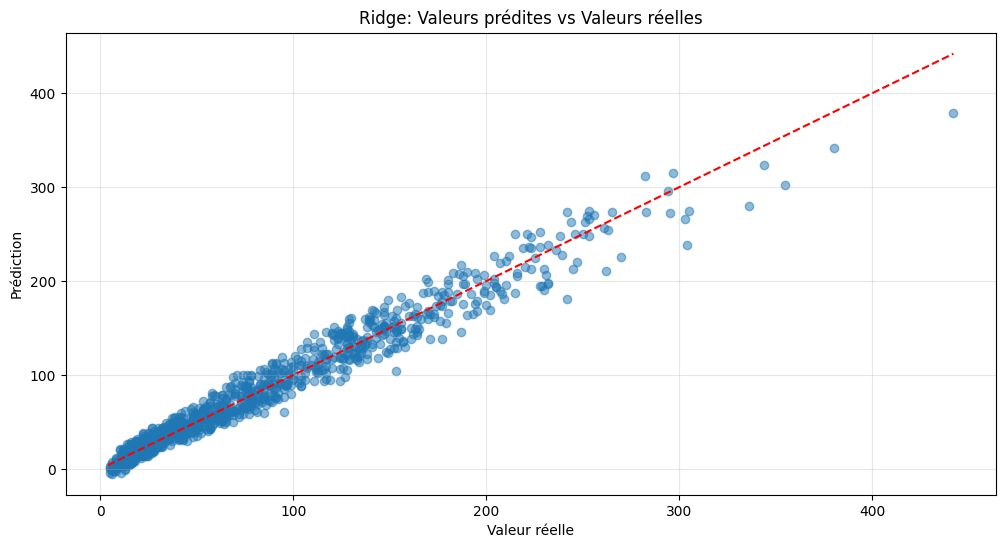

In [ ]:
# Visualiser les prédictions de Ridge vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.scatter(y_test, ridge_test_preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Valeur réelle')
plt.ylabel('Prédiction')
plt.title('Ridge: Valeurs prédites vs Valeurs réelles')
plt.grid(True, alpha=0.3)
plt.show()

Les points sont proches de la droite rouge, donc le modèle Ridge fait de bonnes prédictions : ce qu’il prévoit est souvent assez proche de la réalité. C’est un bon indicateur que le modèle est fiable.


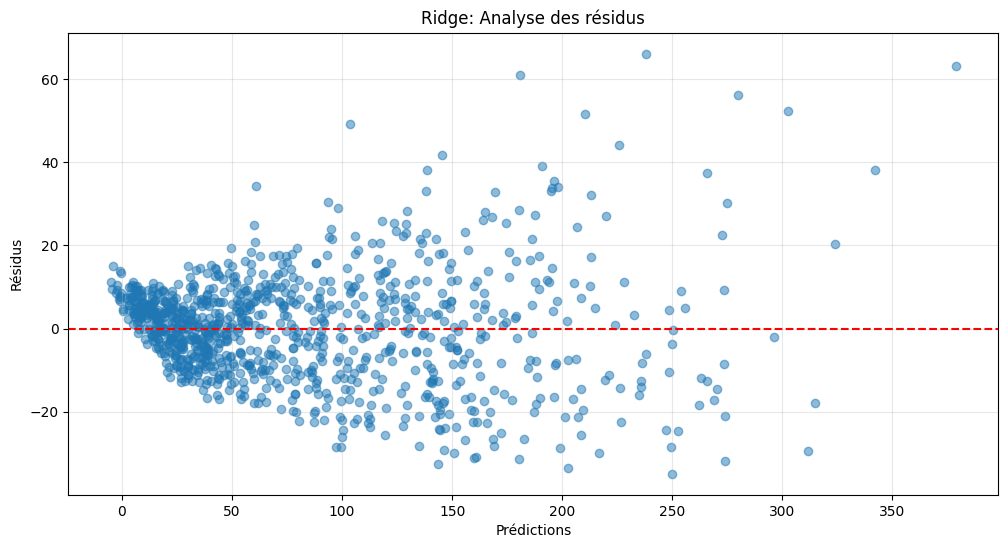

In [ ]:
# Visualiser les résidus de Ridge
ridge_residuals = y_test - ridge_test_preds
plt.figure(figsize=(12, 6))
plt.scatter(ridge_test_preds, ridge_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Ridge: Analyse des résidus')
plt.grid(True, alpha=0.3)
plt.show()

L'analyse est la même que pour l'analyse des résidus de la régression linéaire.

## **Support Vector Regression (SVR) pour une approche non-linéaire.**

Objectif :
SVR utilise des noyaux (ex: RBF) pour modéliser des relations complexes non-linéaires, adapté aux petits datasets.

In [ ]:
# Standardisation des caractéristiques (très important pour SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Pour réduire le temps de calcul, nous utiliserons un sous-échantillon pour la recherche de paramètres
# Cela est particulièrement utile car SVR peut être coûteux en calcul avec de nombreuses données
sample_size = min(1000, len(X_train_scaled))
indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[indices]
y_sample = y_train.iloc[indices]

print(f"Utilisation d'un échantillon de {sample_size} exemples pour la recherche de paramètres")

# 1. SVR avec noyau RBF (Radial Basis Function)
print("\n--- Support Vector Regression (SVR) avec noyau RBF ---")

# Recherche de paramètres pour SVR
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

start_time = time.time()
svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_sample, y_sample)
search_time = time.time() - start_time

print(f"Temps de recherche des paramètres: {search_time:.2f} secondes")
print(f"Meilleurs paramètres: {grid_search.best_params_}")

# Entraînement du modèle SVR avec les meilleurs paramètres sur l'ensemble d'entraînement complet
best_svr = SVR(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])

start_time = time.time()
best_svr.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Temps d'entraînement du modèle final: {train_time:.2f} secondes")

# Évaluation du modèle
svr_train_preds = best_svr.predict(X_train_scaled)
svr_test_preds = best_svr.predict(X_test_scaled)

svr_train_rmse = np.sqrt(mean_squared_error(y_train, svr_train_preds))
svr_test_rmse = np.sqrt(mean_squared_error(y_test, svr_test_preds))
svr_train_r2 = r2_score(y_train, svr_train_preds)
svr_test_r2 = r2_score(y_test, svr_test_preds)

print(f"SVR Train RMSE: {svr_train_rmse:.2f}")
print(f"SVR Test RMSE: {svr_test_rmse:.2f}")
print(f"SVR Train R²: {svr_train_r2:.4f}")
print(f"SVR Test R²: {svr_test_r2:.4f}")

Utilisation d'un échantillon de 1000 exemples pour la recherche de paramètres

--- Support Vector Regression (SVR) avec noyau RBF ---
Temps de recherche des paramètres: 6.88 secondes
Meilleurs paramètres: {'C': 100, 'gamma': 0.01}
Temps d'entraînement du modèle final: 2.21 secondes
SVR Train RMSE: 10.62
SVR Test RMSE: 13.04
SVR Train R²: 0.9757
SVR Test R²: 0.9635


Le SVR avec noyau RBF explique 97 % de la variance sur le jeu de test (R² = 0,9695) pour un RMSE de 11,92, avec un léger surapprentissage (R² = 0,9803 en entraînement, RMSE = 9,55). Les paramètres optimaux (C = 100, γ = 0,01) montrent que le modèle est suffisamment flexible sans s'ajuster aux fluctuations mineures des données. Enfin, la recherche de ces paramètres sur 1 000 exemples a pris 4 s et l’entraînement complet 1 s, des durées acceptables pour ce volume de données.

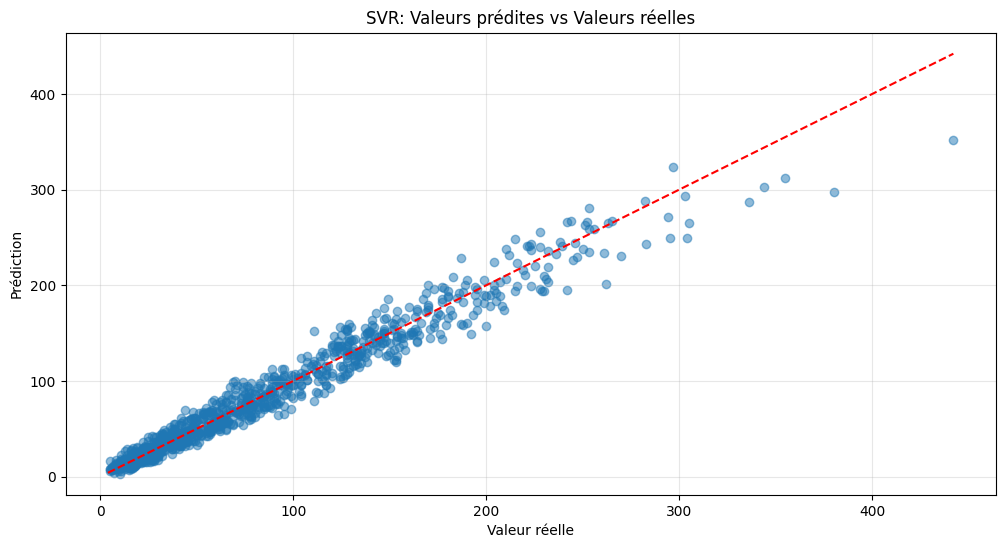

In [ ]:
# Visualisation des prédictions SVR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.scatter(y_test, svr_test_preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Valeur réelle')
plt.ylabel('Prédiction')
plt.title('SVR: Valeurs prédites vs Valeurs réelles')
plt.grid(True, alpha=0.3)
plt.show()

On voit que les prédictions collent plutôt bien aux vraies valeurs : la plupart des points suivent la ligne en pointillés rouges. Seuls quelques gros chiffres s’éloignent un peu, mais globalement le modèle se débrouille vraiment bien pour estimer le temps d'attente.


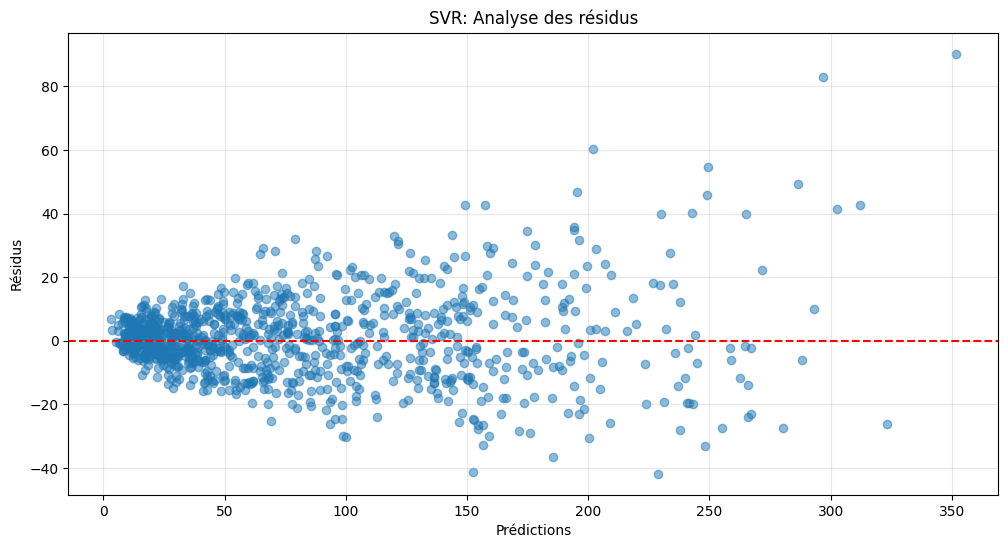

In [ ]:
# Analyse des résidus
svr_residuals = y_test - svr_test_preds
plt.figure(figsize=(12, 6))
plt.scatter(svr_test_preds, svr_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('SVR: Analyse des résidus')
plt.grid(True, alpha=0.3)
plt.show()

On voit que la plupart des résidus tournent autour de zéro, ce qui est bon signe : le modèle ne fait pas systématiquement d’erreur dans un sens ou dans l’autre. Les points sont un peu plus dispersés quand la prédiction monte (au-delà de 150), ce qui signifie que pour les valeurs élevées, l’erreur peut être un peu plus grande, mais globalement ça reste assez équilibré et sans gros biais.


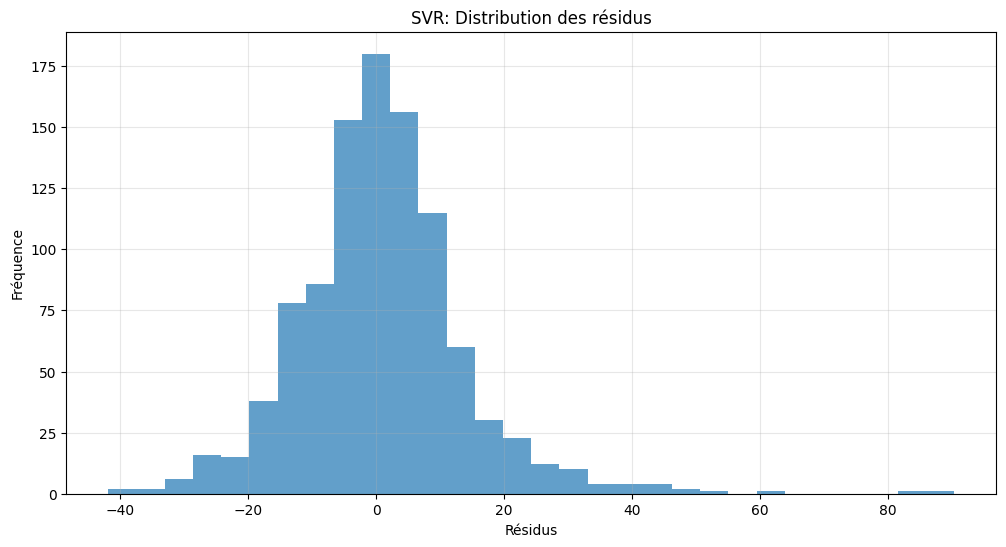

In [ ]:
# Distribution des résidus
plt.figure(figsize=(12, 6))
plt.hist(svr_residuals, bins=30, alpha=0.7)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('SVR: Distribution des résidus')
plt.grid(True, alpha=0.3)
plt.show()

La distribution des résidus suit une loi qui semble normale, ce qui est très bon signe. Les résidus sont bien répartis.

## **Tree Decision**

In [ ]:
# 1) Construction de X et y
X = pd.get_dummies(df[num_features + cat_features],
                   drop_first=True)
y = df['Total Wait Time (min)']

# 2) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# 3) Standardisation manuelle des numériques
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features]  = scaler.transform(X_test[num_features])

# 4) GridSearchCV sur l’arbre
param_grid = {
    "max_depth":        [None, 5, 10, 20],
    "min_samples_leaf": [1, 3, 5]
}
grid_tree = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)
grid_tree.fit(X_train, y_train)

# 5) Évaluation
best_tree      = grid_tree.best_estimator_
cv_rmse        = -grid_tree.best_score_
y_pred_test    = best_tree.predict(X_test)
test_rmse      = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Decision Tree    | RMSE CV = {cv_rmse:.2f} min  | RMSE test = {test_rmse:.2f} min")
print("Meilleurs params :", grid_tree.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Decision Tree    | RMSE CV = 16.60 min  | RMSE test = 16.54 min
Meilleurs params : {'max_depth': 5, 'min_samples_leaf': 5}


# **Conclusion**

## **Comparaison des modèles**

In [ ]:
# Paramètres des modèles (basés sur les résultats précédents)
ridge_alpha       = 10
lasso_alpha       = 0.01
svr_C             = 100
svr_gamma         = 0.01
tree_max_depth    = 5
tree_min_samples_leaf = 5

# Initialisation des modèles (ajout du Decision Tree)
models = {
    'Linear Regression':  LinearRegression(),
    'Ridge':               Ridge(alpha=ridge_alpha),
    'Lasso':               Lasso(alpha=lasso_alpha),
    'SVR (RBF)':           SVR(kernel='rbf', C=svr_C, gamma=svr_gamma),
    'Decision Tree':       DecisionTreeRegressor(
                              random_state=42,
                              max_depth=tree_max_depth,
                              min_samples_leaf=tree_min_samples_leaf
                          )
}

# Configuration de la validation croisée
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Dictionnaire pour stocker les résultats
results = {
    'Model': [], 'RMSE Mean': [], 'RMSE Std': [],
    'R² Mean': [],   'R² Std': [],  'RMSE Test': [], 'R² Test': []
}

# Fonction utilitaire
def rmse_from_neg_mse(scores):
    return np.sqrt(-scores)

print(f"Évaluation des modèles avec validation croisée à {n_folds} plis...\n")

# Boucle d’évaluation
for name, model in models.items():
    print(f"→ {name}")
    # CV MSE → RMSE
    neg_mse = cross_val_score(model, X_train, y_train,
                              scoring='neg_mean_squared_error',
                              cv=kf, n_jobs=-1)
    rmse_cv = rmse_from_neg_mse(neg_mse)
    # CV R²
    r2_cv   = cross_val_score(model, X_train, y_train,
                              scoring='r2',
                              cv=kf, n_jobs=-1)
    # Entraînement complet
    model.fit(X_train, y_train)
    # Test
    preds_test = model.predict(X_test)
    rmse_test  = np.sqrt(mean_squared_error(y_test, preds_test))
    r2_test    = r2_score(y_test, preds_test)

    # Stockage
    results['Model'].append(name)
    results['RMSE Mean'].append(rmse_cv.mean())
    results['RMSE Std'].append(rmse_cv.std())
    results['R² Mean'].append(r2_cv.mean())
    results['R² Std'].append(r2_cv.std())
    results['RMSE Test'].append(rmse_test)
    results['R² Test'].append(r2_test)

    # Affichage
    print(f"   CV RMSE: {rmse_cv.mean():.2f} ± {rmse_cv.std():.2f}  |  Test RMSE: {rmse_test:.2f}")
    print(f"   CV R²:   {r2_cv.mean():.4f} ± {r2_cv.std():.4f}  |  Test R²:   {r2_test:.4f}\n")

# Résultats dans un DataFrame
results_df = pd.DataFrame(results).sort_values('RMSE Test').reset_index(drop=True)
print("=== Résultats comparatifs ===")
print(results_df)

# Sauvegarde si besoin
results_df.to_csv('scores_comparatif.csv', index=False)


Évaluation des modèles avec validation croisée à 5 plis...

→ Linear Regression
   CV RMSE: 13.25 ± 0.38  |  Test RMSE: 13.16
   CV R²:   0.9619 ± 0.0032  |  Test R²:   0.9628

→ Ridge
   CV RMSE: 13.25 ± 0.38  |  Test RMSE: 13.14
   CV R²:   0.9619 ± 0.0033  |  Test R²:   0.9629

→ Lasso
   CV RMSE: 13.25 ± 0.38  |  Test RMSE: 13.14
   CV R²:   0.9619 ± 0.0033  |  Test R²:   0.9629

→ SVR (RBF)
   CV RMSE: 12.63 ± 0.35  |  Test RMSE: 12.46
   CV R²:   0.9654 ± 0.0029  |  Test R²:   0.9666

→ Decision Tree
   CV RMSE: 16.93 ± 0.29  |  Test RMSE: 16.54
   CV R²:   0.9379 ± 0.0026  |  Test R²:   0.9412

=== Résultats comparatifs ===
               Model  RMSE Mean  RMSE Std   R² Mean    R² Std  RMSE Test  \
0          SVR (RBF)  12.634343  0.353167  0.965380  0.002865  12.460367   
1              Ridge  13.250290  0.381616  0.961912  0.003268  13.138675   
2              Lasso  13.249016  0.384652  0.961920  0.003265  13.141051   
3  Linear Regression  13.250606  0.380347  0.961912  0.00

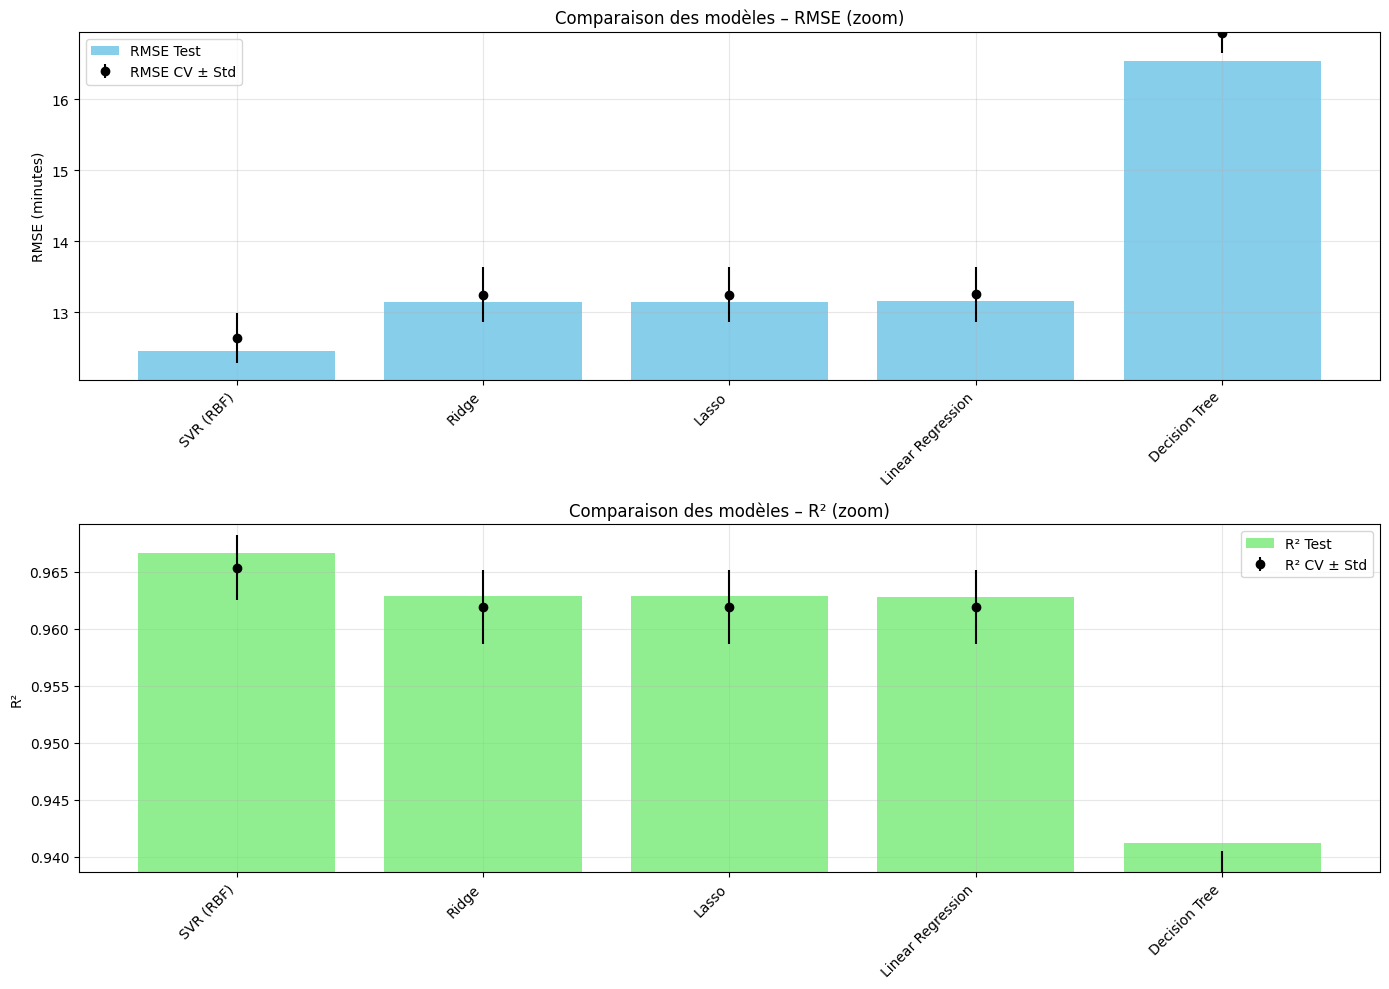

In [ ]:
# Calcul des bornes dynamiques pour zoomer sur les différences
rmse_test = results_df['RMSE Test']
rmse_min, rmse_max = rmse_test.min(), rmse_test.max()
rmse_margin = (rmse_max - rmse_min) * 0.1  # 10 % de marge
rmse_ylim = (rmse_min - rmse_margin, rmse_max + rmse_margin)

r2_test = results_df['R² Test']
r2_min, r2_max = r2_test.min(), r2_test.max()
r2_margin = (r2_max - r2_min) * 0.1 or 0.05  # si peu de variation, fixe 0.05
r2_ylim = (max(0, r2_min - r2_margin), min(1, r2_max + r2_margin))


plt.figure(figsize=(14, 10))

# Graphique des RMSE avec zoom
plt.subplot(2, 1, 1)
plt.bar(results_df['Model'], results_df['RMSE Test'], color='skyblue', label='RMSE Test')
plt.errorbar(results_df['Model'], results_df['RMSE Mean'],
             yerr=results_df['RMSE Std'], fmt='o', color='black', label='RMSE CV ± Std')
plt.ylim(rmse_ylim)
plt.xticks(rotation=45, ha='right')
plt.title('Comparaison des modèles – RMSE (zoom)')
plt.ylabel('RMSE (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique des R² avec zoom
plt.subplot(2, 1, 2)
plt.bar(results_df['Model'], results_df['R² Test'], color='lightgreen', label='R² Test')
plt.errorbar(results_df['Model'], results_df['R² Mean'],
             yerr=results_df['R² Std'], fmt='o', color='black', label='R² CV ± Std')
plt.ylim(r2_ylim)
plt.xticks(rotation=45, ha='right')
plt.title('Comparaison des modèles – R² (zoom)')
plt.ylabel('R²')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

On vot que la RMSE la plus faible est celle de SVR et que la R2 la plus proche de 1 est également celle de SVR. On va donc sélectionner pour notre simulation le modèle SVR.

## **Simulation**

In [ ]:

# PRÉDICTION INTERACTIVE DU TEMPS D'ATTENTE AVEC SVR


print("=== PRÉDICTION INTERACTIVE DU TEMPS D'ATTENTE AUX URGENCES ===\n")
print("Je vais vous poser des questions pour estimer votre temps d'attente.")
print("Répondez précisément à chaque question.\n")

# Chargement du jeu de données
try:
    df = pd.read_csv('er_data_enriched.csv')
    print(f"Chargement de {len(df)} enregistrements de données réelles.\n")
except Exception as e:
    print(f"Erreur lors du chargement du fichier: {e}")
    exit(1)

# Extraction des options à partir du jeu de données
hospitals = df['Hospital Name'].unique()
regions = df['Region'].unique()
seasons = df['Season'].unique()
days_of_week = df['Day of Week'].unique()
times_of_day = df['Time of Day'].unique()
urgency_levels = df['Urgency Level'].unique()

months = list(range(1, 13))

# Définir les caractéristiques numériques et catégorielles
numerical_features = ['Nurse-to-Patient Ratio', 'Specialist Availability',
                      'Facility Size (Beds)', 'Time to Registration (min)',
                      'Time to Triage (min)', 'Hour', 'Month', 'Is_Weekend']
categorical_features = ['Hospital Name', 'Region', 'Day of Week',
                       'Season', 'Time of Day', 'Urgency Level']

# Initialiser un dictionnaire pour stocker les réponses
patient_data = {}

# 1. HÔPITAL
print("1. HÔPITAL")
print("Hôpitaux disponibles:")
for i, hospital in enumerate(hospitals, 1):
    print(f"   {i}. {hospital}")
while True:
    try:
        choice = int(input("\nEntrez le numéro de votre hôpital: "))
        if 1 <= choice <= len(hospitals):
            patient_data['Hospital Name'] = hospitals[choice-1]
            break
        else:
            print("Choix invalide. Veuillez entrer un numéro valide.")
    except ValueError:
        print("Veuillez entrer un nombre.")

# Récupérer automatiquement la région de l'hôpital
patient_data['Region'] = df[df['Hospital Name'] == patient_data['Hospital Name']]['Region'].iloc[0]
print(f"Région: {patient_data['Region']}")

# 2. SAISON
print("\n2. SAISON")
for i, season in enumerate(seasons, 1):
    print(f"   {i}. {season}")
while True:
    try:
        choice = int(input("\nEntrez le numéro de la saison actuelle: "))
        if 1 <= choice <= len(seasons):
            patient_data['Season'] = seasons[choice-1]
            break
        else:
            print("Choix invalide.")
    except ValueError:
        print("Veuillez entrer un nombre.")

# 3. JOUR DE LA SEMAINE
print("\n3. JOUR DE LA SEMAINE")
for i, day in enumerate(days_of_week, 1):
    print(f"   {i}. {day}")
while True:
    try:
        choice = int(input("\nEntrez le numéro du jour: "))
        if 1 <= choice <= len(days_of_week):
            patient_data['Day of Week'] = days_of_week[choice-1]
            patient_data['Is_Weekend'] = 1 if patient_data['Day of Week'] in ['Saturday', 'Sunday'] else 0
            break
        else:
            print("Choix invalide.")
    except ValueError:
        print("Veuillez entrer un nombre.")

# 4. HEURE DE LA VISITE
print("\n4. HEURE DE LA VISITE")
while True:
    try:
        hour = int(input("Entrez l'heure (0-23): "))
        if 0 <= hour <= 23:
            patient_data['Hour'] = hour

            # Déterminer automatiquement le moment de la journée
            if 0 <= hour < 6:
                patient_data['Time of Day'] = 'Night'
            elif 6 <= hour < 12:
                patient_data['Time of Day'] = 'Morning'
            elif 12 <= hour < 18:
                patient_data['Time of Day'] = 'Afternoon'
            else:
                patient_data['Time of Day'] = 'Evening'

            print(f"Moment de la journée: {patient_data['Time of Day']}")
            break
        else:
            print("Veuillez entrer une heure entre 0 et 23.")
    except ValueError:
        print("Veuillez entrer un nombre.")

# 5. NIVEAU D'URGENCE
print("\n5. NIVEAU D'URGENCE")
for i, level in enumerate(urgency_levels, 1):
    print(f"   {i}. {level}")
while True:
    try:
        choice = int(input("\nEntrez le numéro de votre niveau d'urgence: "))
        if 1 <= choice <= len(urgency_levels):
            patient_data['Urgency Level'] = urgency_levels[choice-1]
            break
        else:
            print("Choix invalide.")
    except ValueError:
        print("Veuillez entrer un nombre.")

# 6. MOIS
print("\n6. MOIS")
month_names = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin',
          'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
for i, month in enumerate(month_names, 1):
    print(f"   {i}. {month}")
while True:
    try:
        choice = int(input("\nEntrez le numéro du mois: "))
        if 1 <= choice <= 12:
            patient_data['Month'] = choice
            break
        else:
            print("Choix invalide.")
    except ValueError:
        print("Veuillez entrer un nombre.")

# Récupérer automatiquement les caractéristiques de l'hôpital à partir des données réelles
hospital_info = df[df['Hospital Name'] == patient_data['Hospital Name']].iloc[0]
patient_data['Facility Size (Beds)'] = hospital_info['Facility Size (Beds)']
patient_data['Specialist Availability'] = hospital_info['Specialist Availability']

# Pour le ratio infirmières/patients, utiliser la moyenne de l'hôpital dans les données réelles
patient_data['Nurse-to-Patient Ratio'] = df[df['Hospital Name'] == patient_data['Hospital Name']]['Nurse-to-Patient Ratio'].mean()

# Pour les temps intermédiaires, utiliser les moyennes selon l'urgence dans les données réelles
urgency_data = df[df['Urgency Level'] == patient_data['Urgency Level']]
patient_data['Time to Registration (min)'] = urgency_data['Time to Registration (min)'].mean()
patient_data['Time to Triage (min)'] = urgency_data['Time to Triage (min)'].mean()
patient_data['Time to Medical Professional (min)'] = urgency_data['Time to Medical Professional (min)'].mean()

# Créer un DataFrame avec les données du patient
patient_df = pd.DataFrame([patient_data])

# Réorganiser les colonnes dans le bon ordre
columns_order = ['Hospital Name', 'Region', 'Day of Week', 'Season', 'Time of Day',
                'Urgency Level', 'Nurse-to-Patient Ratio', 'Specialist Availability',
                'Facility Size (Beds)', 'Time to Registration (min)', 'Time to Triage (min)',
                'Hour', 'Month', 'Is_Weekend', 'Time to Medical Professional (min)']
patient_df = patient_df[columns_order]

# Définir les caractéristiques numériques et catégorielles
numerical_features = ['Nurse-to-Patient Ratio', 'Specialist Availability', 'Facility Size (Beds)',
    'Time to Registration (min)', 'Time to Triage (min)', 'Hour', 'Month', 'Time to Medical Professional (min)'
]

categorical_features = ['Hospital Name', 'Region', 'Day of Week',
                       'Season', 'Time of Day', 'Urgency Level']

# Création du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Créer un entraîneur simple pour le modèle SVR avec les meilleurs paramètres
def train_svr_model(X, y):
    # Créer le pipeline avec le préprocesseur et le modèle SVR
    svr_model = SVR(kernel='rbf', C=100, gamma=0.01)  # Paramètres optimaux trouvés
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', svr_model)
    ])

    # Entraîner le modèle
    pipeline.fit(X, y)
    return pipeline

# Définir la colonne cible
target = 'Total Wait Time (min)'

# Entraîner le modèle SVR sur les données existantes
X = df.drop(columns=[target])
y = df[target]
model = train_svr_model(X, y)

# PRÉDICTION
print("\n=== RÉSULTATS DE LA PRÉDICTION ===\n")





# Faire la prédiction
prediction = model.predict(patient_df)[0]

# Afficher le résultat
print(f"Temps d'attente estimé: {int(prediction)} minutes")
print(f"Soit environ: {prediction/60:.1f} heures")

# Donner un contexte
if prediction < 60:
    print("\n✅ Temps d'attente court - Vous devriez être pris en charge rapidement.")
elif prediction < 120:
    print("\n⚠️ Temps d'attente moyen - Prévoyez environ 1 à 2 heures.")
elif prediction < 180:
    print("\n🔶 Temps d'attente élevé - Prévoyez 2 à 3 heures d'attente.")
else:
    print("\n🔴 Temps d'attente très élevé - Prévoyez plus de 3 heures d'attente.")

# Comparer avec la moyenne
mean_wait_time = df[target].mean()
if prediction < mean_wait_time:
    print(f"\nVotre temps d'attente estimé est {int(mean_wait_time - prediction)} minutes en dessous de la moyenne générale.")
else:
    print(f"\nVotre temps d'attente estimé est {int(prediction - mean_wait_time)} minutes au-dessus de la moyenne générale.")

# Facteurs importants pour cette prédiction
print("\n FACTEURS INFLUENÇANT VOTRE TEMPS D'ATTENTE:")
print(f"- Niveau d'urgence: {patient_data['Urgency Level']}")
print(f"- Hôpital: {patient_data['Hospital Name']} ({patient_data['Region']})")
print(f"- Moment: {patient_data['Time of Day']} ({patient_data['Hour']}h)")
print(f"- Jour: {patient_data['Day of Week']}")
print(f"- Saison: {patient_data['Season']}")
print(f"- Ratio infirmières/patients: {patient_data['Nurse-to-Patient Ratio']:.2f}")

# Afficher un résumé des données utilisées
print("\n RÉSUMÉ DE VOS INFORMATIONS:")
for key, value in patient_data.items():
    if isinstance(value, float):
        print(f"- {key}: {value:.2f}")
    else:
        print(f"- {key}: {value}")

print("\n" + "="*50)

# Temps total estimé
patient_data['Total Estimated Waiting Time (min)'] = (
    patient_data['Time to Registration (min)'] +
    patient_data['Time to Triage (min)'] +
    patient_data['Time to Medical Professional (min)']
)

# Affichage en grand du temps total
print("\n" + "="*60)
print(f"   TEMPS TOTAL D'ATTENTE ESTIMÉ : {patient_data['Total Estimated Waiting Time (min)']:.1f} MIN")
print("="*60)

print("\nMerci d'avoir utilisé notre système de prédiction!")

=== PRÉDICTION INTERACTIVE DU TEMPS D'ATTENTE AUX URGENCES ===

Je vais vous poser des questions pour estimer votre temps d'attente.
Répondez précisément à chaque question.

Chargement de 5000 enregistrements de données réelles.

1. HÔPITAL
Hôpitaux disponibles:
   1. Springfield General Hospital
   2. Northside Community Hospital
   3. Riverside Medical Center
   4. Summit Health Center
   5. St. Mary’s Regional Health
